# MicroDiag

In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../')

In [2]:
SOCKSHOP_DATASET_ID = "9n6mf"

In [22]:
from diagnoser import diag

In [11]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=False,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": True,
        "step2_clustering_method_name": "changepoint",
        "step2_changepoint_n_bkps": 1,
        "step2_changepoint_proba_threshold": 0.5,
        "step2_clustering_choice_method": "max_members_changepoint",
        "step2_changepoint_cluster_selection_method": "leaf",
        "step2_changepoint_cluster_selection_epsilon": 3.0,
        "step2_changepoint_allow_single_cluster": True,
        "step2_clustering_n_workers": 1,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    validation_filtering=(True, 4*5)
)

In [16]:
import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning)
import lingam
from lingam.utils import make_dot

In [8]:
np.set_printoptions(precision=3, suppress=True)
np.random.seed(100)

In [98]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-memory-hog", "user")][0]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1],
    data_df_by_metric_type["services"][-1],
    # data_df_by_metric_type["middlewares"][-1],
], axis=1)
dataset.shape

(180, 128)

In [99]:
import networkx as nx
import diagnoser.metric_node as mn

nodes: mn.MetricNodes = mn.MetricNodes.from_dataframe(dataset)
mapping = {node: i for i, node in enumerate(nodes)}
init_g: nx.Graph = diag.prepare_init_graph(
    nodes, record.pk, enable_prior_knowledge=True,
)
RG: nx.Graph = diag.build_subgraph_of_removal_edges(nodes, record.pk)

In [100]:
prior_knowledge = np.full((len(nodes), len(nodes)), -1)
for u, v in RG.edges:
    prior_knowledge[mapping[u], mapping[v]] = 0
    prior_knowledge[mapping[v], mapping[u]] = 0
np.fill_diagonal(prior_knowledge, -1)
prior_knowledge

array([[-1, -1, -1, ...,  0,  0,  0],
       [-1, -1, -1, ...,  0,  0,  0],
       [-1, -1, -1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., -1,  0,  0],
       [ 0,  0,  0, ...,  0, -1, -1],
       [ 0,  0,  0, ...,  0, -1, -1]])

In [101]:
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

model = lingam.DirectLiNGAM(prior_knowledge=prior_knowledge)
model.fit(dataset)

In [102]:
adjacency_ = pd.DataFrame(np.abs(model.adjacency_matrix_), columns=dataset.columns.tolist(), index=dataset.columns.tolist())
G = nx.from_pandas_adjacency(adjacency_.T, create_using=nx.DiGraph)

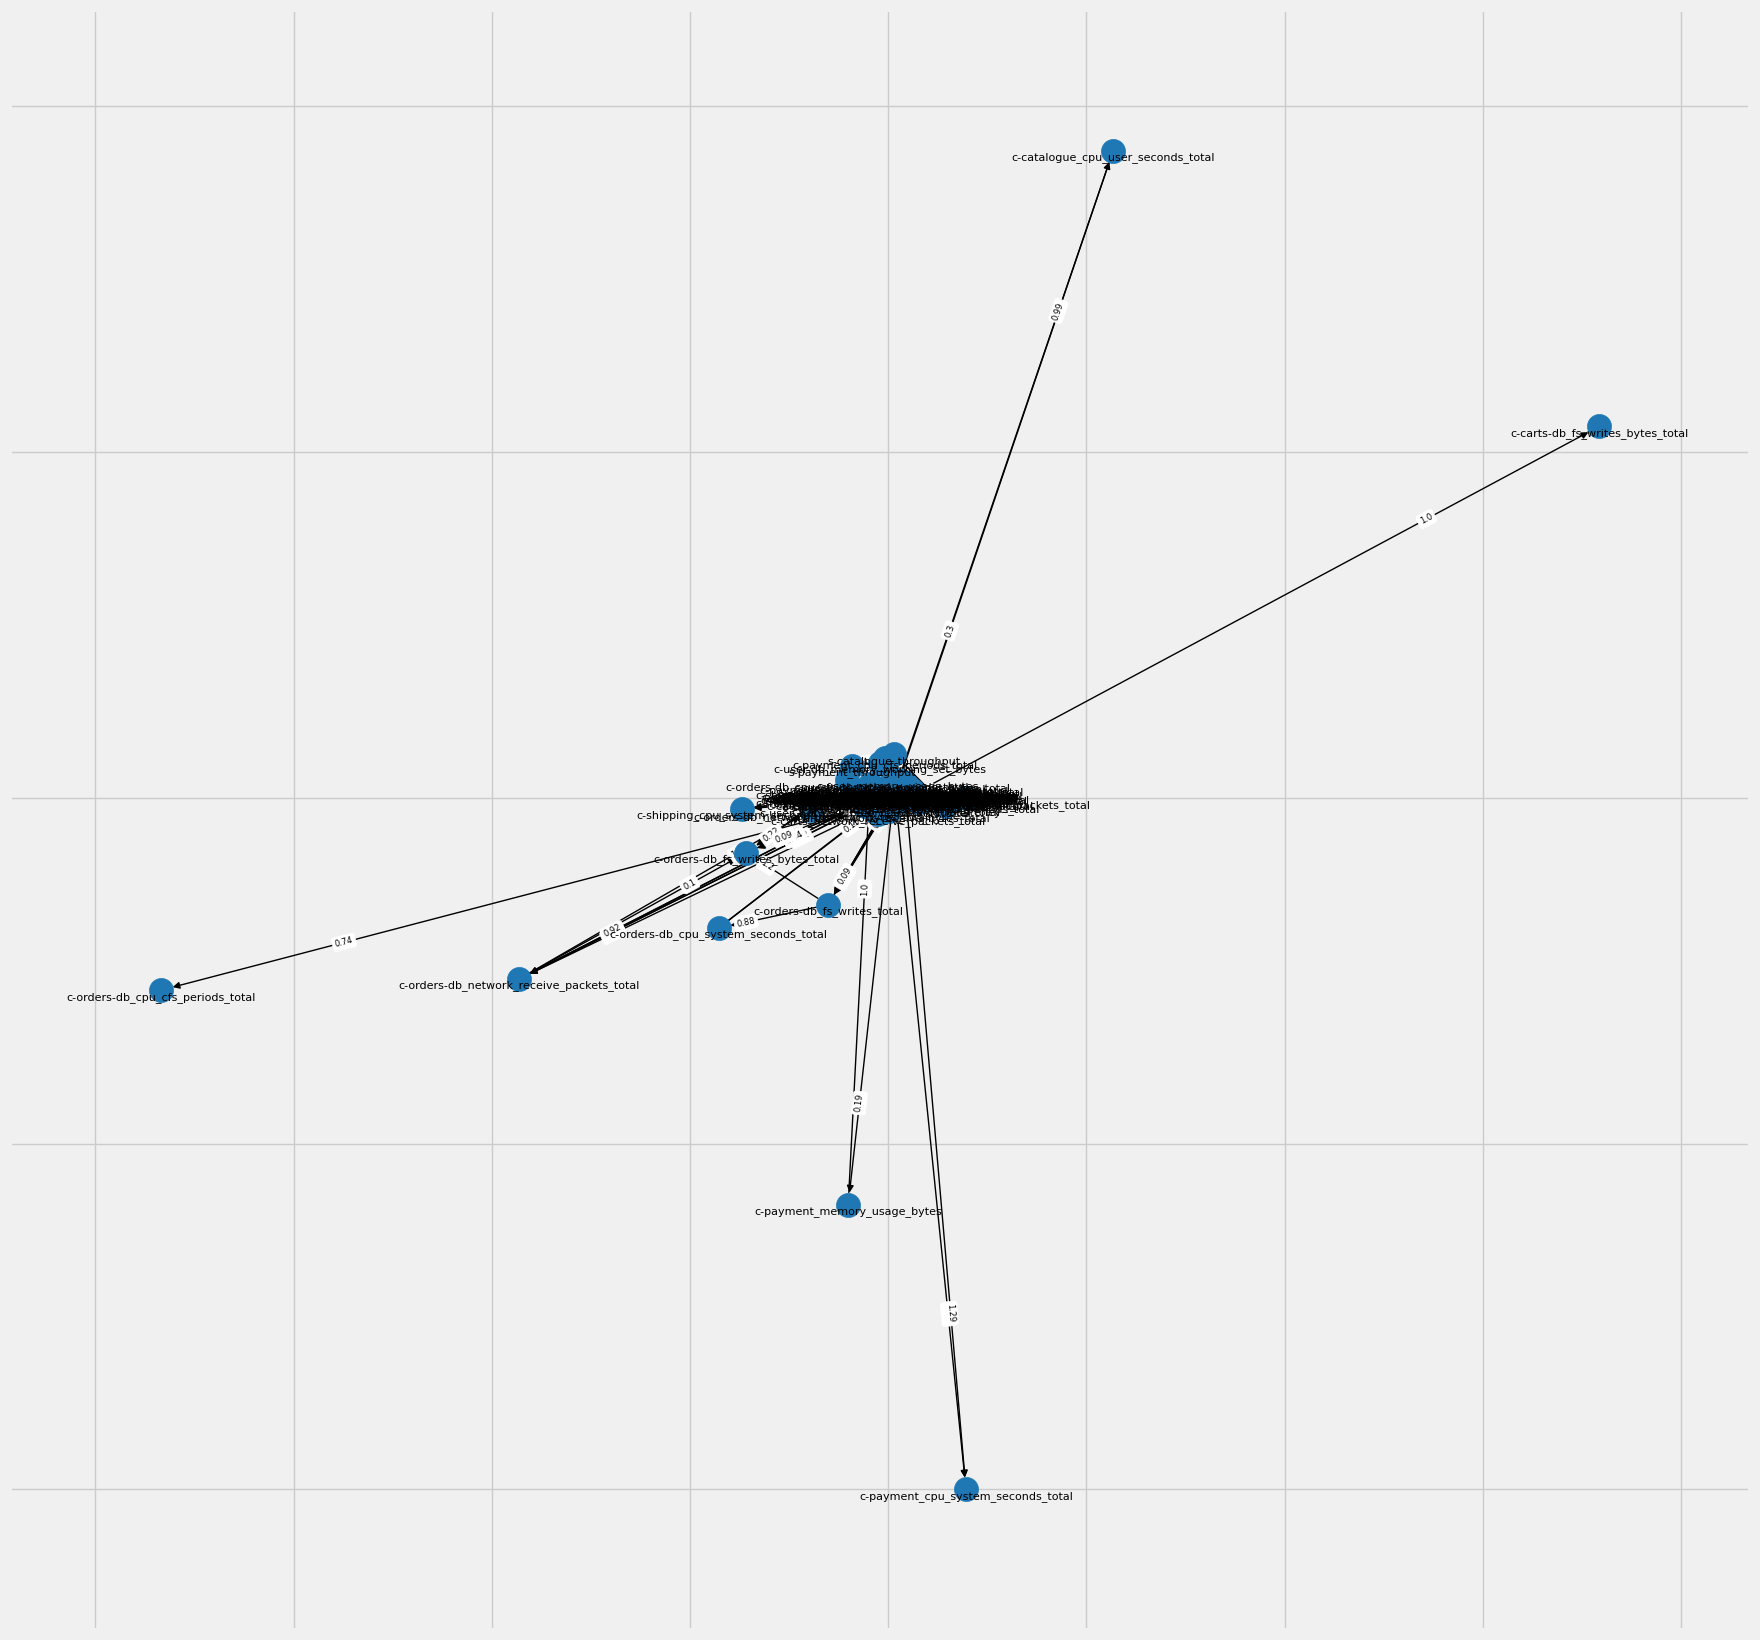

In [103]:
from notebooklib import plot

plot.plot_causal_graph(G)

In [116]:
G_ = G.copy()
corr = np.corrcoef(dataset.values.T)  # calculate pearson correlation
for i in G_.nodes:
    for j in G_.nodes:
        if i == j:
            continue
        if G_.has_edge(i, j):
            G_.edges[i, j]["weight"] = abs(corr[list(G_.nodes).index(i)][list(G_.nodes).index(j)])

rank = nx.pagerank(G_.reverse(), alpha=0.85)
sorted(rank.items(), key=lambda x: x[1], reverse=True)[:10]

True


[('s-orders_throughput', 0.12733852052174743),
 ('c-front-end_memory_rss', 0.10995023087068813),
 ('s-user_latency', 0.04795406440217083),
 ('s-orders_latency', 0.036687668931231245),
 ('c-front-end_network_receive_bytes_total', 0.03122133560059549),
 ('s-front-end_throughput', 0.026994724394043296),
 ('s-catalogue_throughput', 0.024791266212511157),
 ('c-front-end_network_transmit_bytes_total', 0.02289935104917334),
 ('c-user-db_cpu_user_seconds_total', 0.018812589865025407),
 ('s-user_throughput', 0.01668849357679145)]

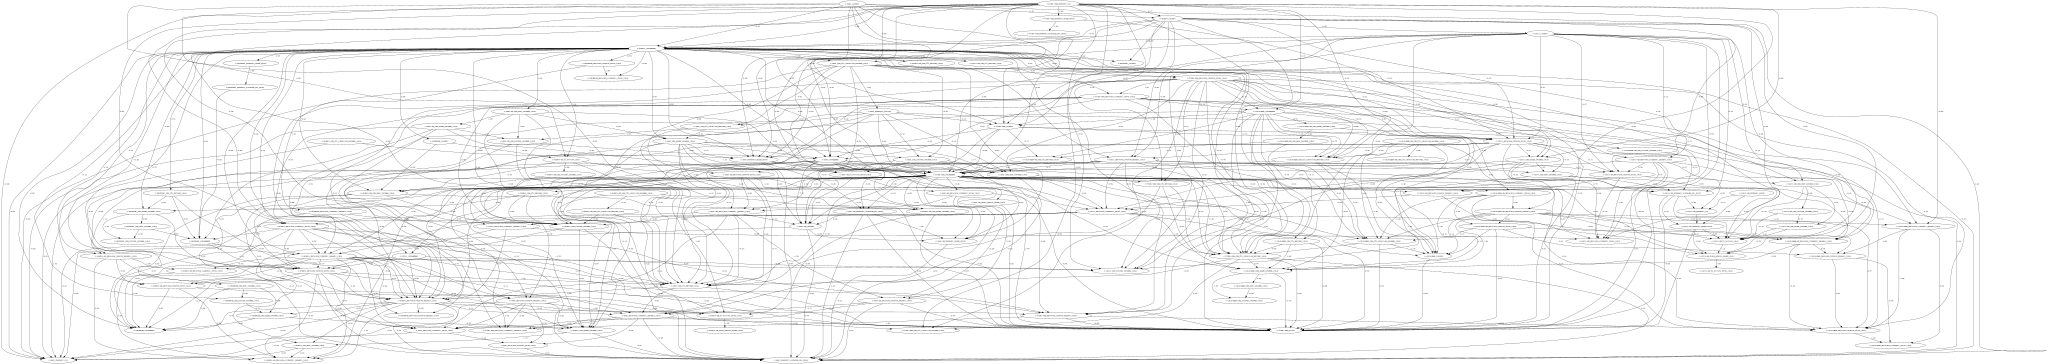

In [105]:
make_dot(model.adjacency_matrix_, labels=dataset.columns.tolist())

In [106]:
diag.build_and_walk_causal_graph(
    dataset, record.pk,
    root_metric_type="latency",
    enable_prior_knowledge=True,
    pc_library="lingam",
    disable_orientation=True,
    walk_method="monitorrank",
    corr_method="left_shift",
    corr_left_shift_lp=5,
)

(<networkx.classes.digraph.DiGraph at 0x7f02a28b2bf0>,
 [('s-orders_throughput', 0.09809971625873322),
  ('c-front-end_memory_rss', 0.06385334832075658),
  ('s-front-end_throughput', 0.03423252815441079),
  ('s-user_latency', 0.03289786690704319),
  ('c-front-end_network_receive_bytes_total', 0.03131788828669048),
  ('c-front-end_network_transmit_bytes_total', 0.02380815606615817),
  ('s-orders_latency', 0.020770793092926756),
  ('s-catalogue_throughput', 0.020597748346735396),
  ('s-user_throughput', 0.02009936730764128),
  ('c-user_cpu_cfs_throttled_seconds_total', 0.017533130416943477),
  ('c-carts_network_receive_bytes_total', 0.015356217879354634),
  ('s-front-end_latency', 0.014222522949936341),
  ('c-user-db_cpu_user_seconds_total', 0.013966138727681996),
  ('c-user_cpu_usage_seconds_total', 0.0135061697360505),
  ('c-orders_network_receive_packets_total', 0.012906160902436386),
  ('c-carts_network_receive_packets_total', 0.011601824321994778),
  ('c-orders_network_transmit_pack